In [1]:
from IPython import get_ipython


 # Tree Modeling

 Talk about xmas and tradition of trees...

 LED and microprocessors are game changers for decorations...

 The goal is to make the Christmas tree to blink in beautiful, complex, patterns.
 Some examples of pattern include
 - rainbow stripes moving vertically/horizontally along the tree,
 - exploding flashes originated in a random spot, emanating across the tree,
 - radial stripes rotating from the center of the tree

 These patterns are generated by a program running on a microcontroller. Here, we call this program a **Pattern-Generator Algorithm**. These algorithms are functions of time and space, thus, the position of the LED bulbs must be known. The process of estimating the LED bulb locations is named **Tree Modeling**.

 We will model the tree in this notebook using videos of the tree blinking tree. Later, we will implement the tree model in the microcontroller's pattern-generator algorithm.

In [2]:
get_ipython().run_line_magic('load_ext', 'autoreload')
get_ipython().run_line_magic('autoreload', '2')
get_ipython().run_line_magic('matplotlib', 'inline')



+1.3377e+04 | 6.60e+01 | 1.36e+03 | 0.00e+00 |
|  232  |  232  | 9551  | +1.3376e+04 | 6.60e+01 | 1.10e+03 | 0.00e+00 |
|  233  |  233  | 9604  | +1.3375e+04 | 6.60e+01 | 1.69e+03 | 0.00e+00 |
|  234  |  234  | 9657  | +1.3372e+04 | 6.60e+01 | 3.03e+03 | 0.00e+00 |
|  235  |  235  | 9719  | +1.3366e+04 | 6.60e+01 | 4.62e+03 | 0.00e+00 |
|  236  |  236  | 9793  | +1.3358e+04 | 6.60e+01 | 4.77e+03 | 0.00e+00 |
|  237  |  237  | 9866  | +1.3351e+04 | 6.60e+01 | 2.97e+03 | 0.00e+00 |
|  238  |  238  | 9925  | +1.3349e+04 | 6.60e+01 | 1.04e+03 | 0.00e+00 |
|  239  |  239  | 9977  | +1.3349e+04 | 6.60e+01 | 9.48e+02 | 0.00e+00 |
|  240  |  240  | 10026 | +1.3348e+04 | 6.60e+01 | 8.38e+02 | 0.00e+00 |
|  241  |  241  | 10079 | +1.3347e+04 | 6.60e+01 | 1.72e+03 | 0.00e+00 |
|  242  |  242  | 10141 | +1.3345e+04 | 6.60e+01 | 3.00e+03 | 0.00e+00 |
|  243  |  243  | 10203 | +1.3340e+04 | 6.60e+01 | 3.82e+03 | 0.00e+00 |
|  244  |  244  | 10268 | +1.3335e+04 | 6.60e+01 | 3.38e+03 | 0.00e+00 |
|  2

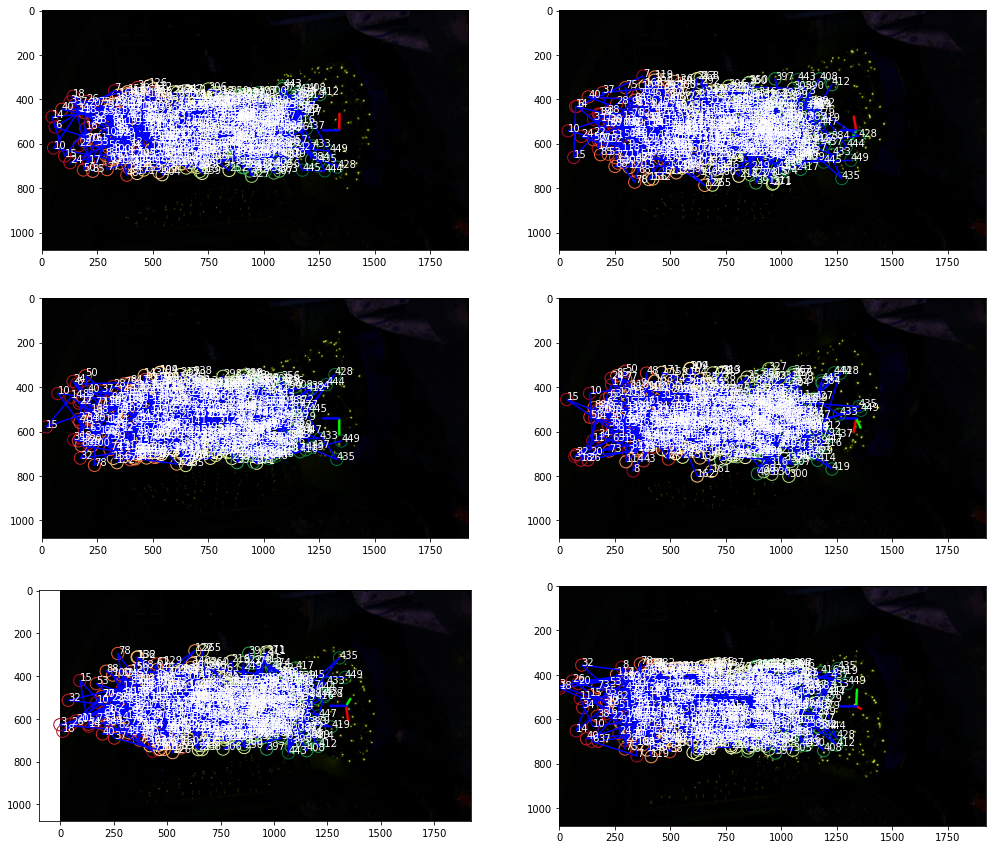

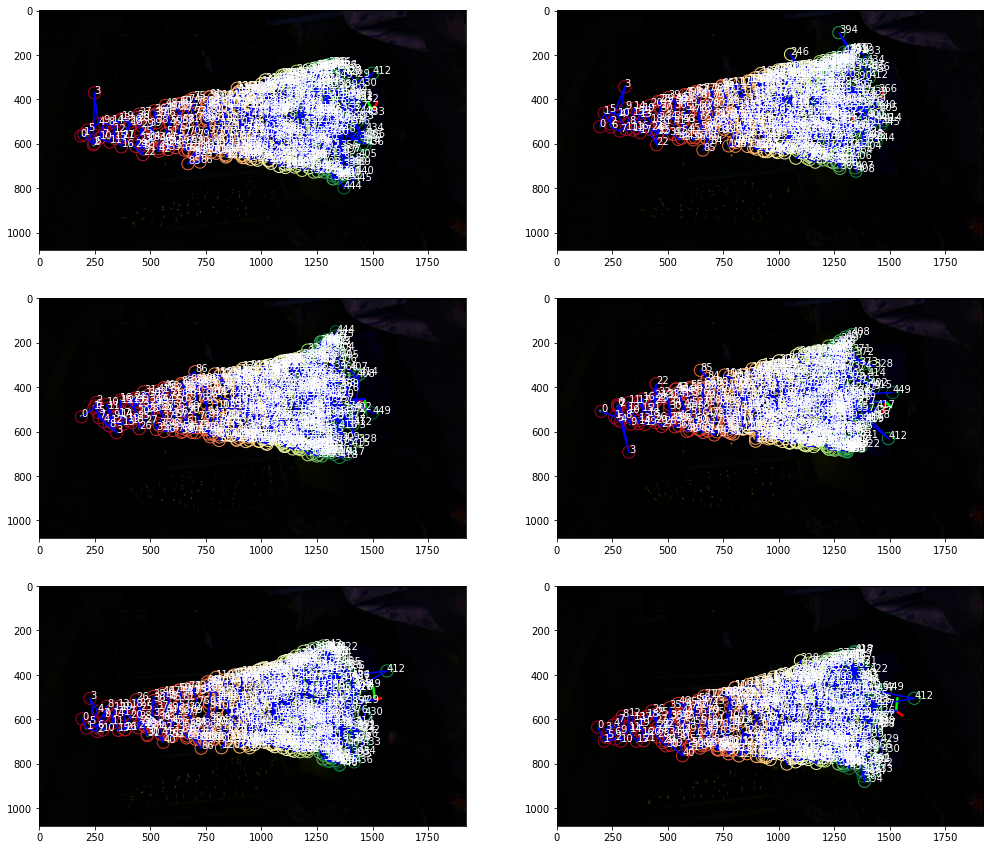

In [9]:
from xmas_lights import load_checkerboard_dataset, load_xmas_tree_dataset, Calibrator
from xmas_lights import load_cam_calib, plot_images, plot_extrinsics, Rod_from_Rxyz
import pickle
import numpy as np

# Nokia camera
calib = pickle.load(open("nokia_intrinsics_fisheye.p", "rb"))
mtx = calib["mtx"]
dist = calib["dist"]

imgpoints, imgs, ground_truth = load_xmas_tree_dataset(dataset_file='geneva_tree_imgpoints.pickle')

xtmodel = Calibrator(imgpoints, mtx.astype('float'), dist.astype('float'))

NPOV, NPTS = 6, 450

rvecs = np.array([Rod_from_Rxyz(0, -1.6, -1.6), 
                  Rod_from_Rxyz(0, -1.6, -1), 
                  Rod_from_Rxyz(0, -1.6, 0), 
                  Rod_from_Rxyz(0, -1.6, 1), 
                  Rod_from_Rxyz(0, -1.6, 2),
                  Rod_from_Rxyz(0, -1.6, 3)])
tvecs = np.array([[0.5, 0, 2], 
                  [0.5, 0, 2], 
                  [0.5, 0, 2], 
                  [0.5, 0, 2], 
                  [0.5, 0, 2],
                  [0.5, 0, 2]], np.float32)
objpoints = (np.random.rand(NPTS, 3) - [0.5, 0.5, 0]) * 0.5
objpoints[:,2] = objpoints[:,2] + np.linspace(1.2, 0, NPTS)

x0 = Calibrator.pack(rvecs, tvecs, objpoints)
lb = x0 - 2
ub = x0 + 2
xtmodel.plot_init_condition(imgs, imgpoints, x0)

rvecs, tvecs, objpoints, res = xtmodel.extrinsic_calibration(x0=x0, ub=ub, lb=lb)
xtmodel.plot_init_condition(imgs, imgpoints, res.x)
print("Average pixel error: %.2f px" % np.sqrt(res.fun / NPTS))

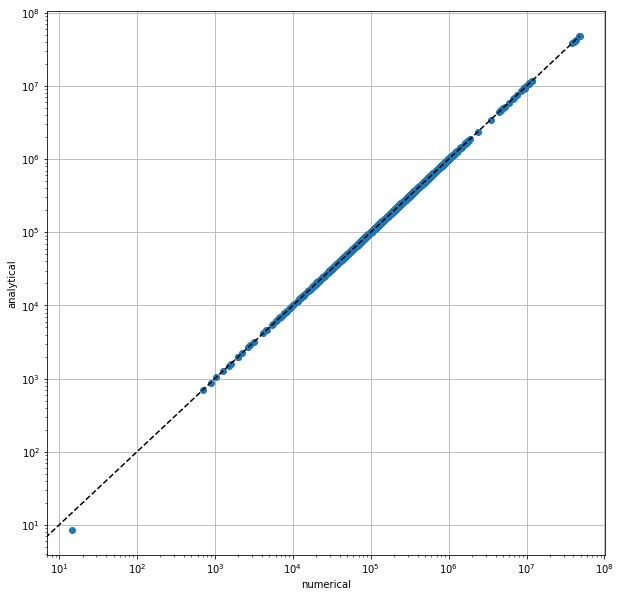

In [10]:
import matplotlib.pyplot as plt 

from mymisc import NumericalGradient
        
def some_fun(x):
    # grad: [2*x0, 1]
    return(x[0]**2 + x[1])

grad1 = NumericalGradient(xtmodel.cost_fcn, x0)
grad2 = xtmodel.jac_fcn(x0)

# offset_value = np.min(np.concatenate(grad1, grad2))
min_value = np.min(np.abs(grad1))
max_value = np.max(np.abs(grad1))

ax = plt.figure(figsize=(10,10))
plt.loglog(grad1 * np.sign(grad1), grad2 * np.sign(grad1), 'o', \
           [min_value, max_value], [min_value, max_value], 'k--')
plt.xlabel('numerical'), plt.ylabel('analytical')
plt.grid()
plt.show()

In [19]:
yin[valid,:].shape

(97, 3)

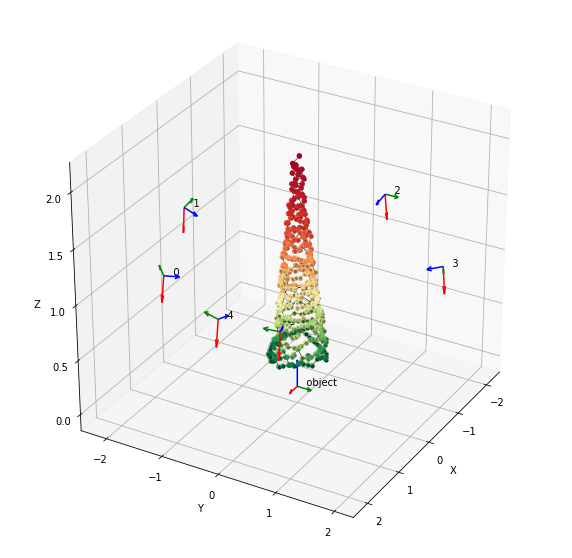

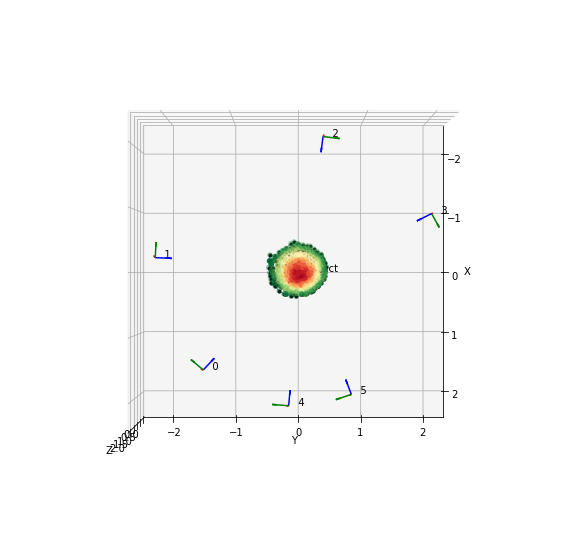

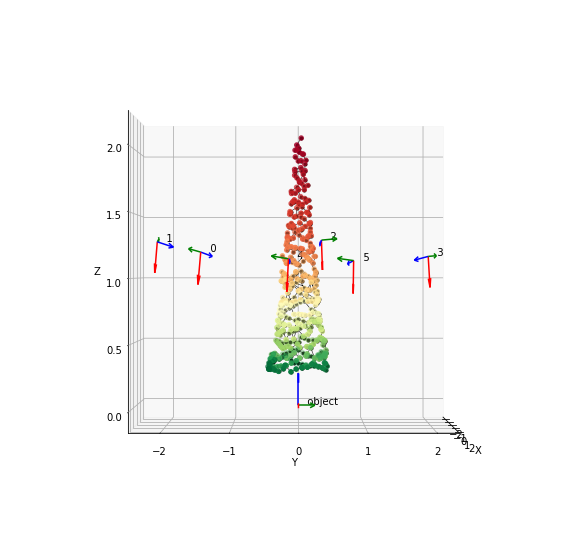

In [32]:
get_ipython().run_line_magic('matplotlib', 'inline')
import numpy as np
import cv2
import matplotlib.pyplot as plt
from mymisc import Rx 
from scipy.interpolate import interp1d

# change inertial frame for easier viz
# R0 = np.array([[0, 0, 1], [0, 1, 0], [-1, 0, 0]]).T
R0 = np.eye(3)
# R0 = Rx(np.pi/2)
t0 = np.array([0, 0, -0.25], np.float64)
objpoints2 = ((objpoints + t0).reshape(-1, 3).dot(R0)).reshape(1, -1, 3)
rvecs2 = [cv2.Rodrigues(cv2.Rodrigues(rvec)[0].dot(R0))[0] for rvec in rvecs]
tvecs2 = [tvec + t0 for tvec in tvecs]

# linearly interpolate missing markers
valid = [np.squeeze(np.all(np.isfinite(pts), axis=2)) for pts in imgpoints]
valid = np.sum(np.array(valid), axis=0) > 1
xin = np.arange(NPTS).astype('float64')
yin = np.squeeze(objpoints).astype('float64')
interp_obj = interp1d(xin[valid], yin[valid,:], kind='linear', axis=0, fill_value=np.nan, bounds_error=False)
yin[~valid] = interp_obj(xin[~valid])

# truncate border markers, who cannot be interpolate (only extrapolated)
valid = np.all(~np.isnan(yin), axis=1)
interp_obj = interp1d(xin[valid], yin[valid,:], kind='nearest', axis=0, fill_value='extrapolate')
yin[~valid] = interp_obj(xin[~valid])

objpoints2 = yin.reshape(1, -1, 3)

ax = plot_extrinsics(rvecs2, tvecs2, objpoints2)
ax.view_init(30, 30)
plt.show()

ax = plot_extrinsics(rvecs2, tvecs2, objpoints2)
ax.view_init(90, 0)
plt.show()

ax = plot_extrinsics(rvecs2, tvecs2, objpoints2)
ax.view_init(0, 0)
plt.show()


 ## Comparing to the ground truth

 The calibrator cannot estimate the true scale, and the position and orientation of the inertial frame. This is fine because we can manually measure the height of the tree and assign a tree origin anywhere we want.

In [105]:
from mymisc import print_c_matrix
# plot_extrinsics(ground_truth["rvecs"], ground_truth["tvecs"], ground_truth["objpoints"])

cart = np.squeeze(objpoints2)  # Nx3
cyl = np.stack((np.sqrt(cart[:,0]**2 + cart[:,1]**2),
                np.arctan2(cart[:,1], cart[:,0]),
                cart[:,2]), axis=1)  # rad, ang, z
ij = np.stack((1.0-cart[:,2]/1.0, cyl[:,1]/(120*np.pi/180) + 0.5), axis=1)
# to project, use [i,j] := [1-z/ztop, ang/awid+0.5], for ztop:=1 m, awid:=120 deg
msg = print_c_matrix(cart)
msg += "\n\n" + print_c_matrix(cyl)
msg += "\n\n" + print_c_matrix(ij)

f = open("outputfile.txt", "w")
f.write(msg)
f.close()

Text(0.5, 0, 'Z')

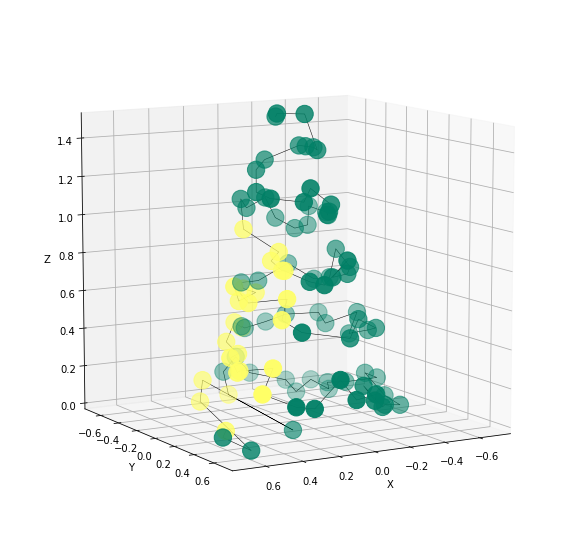

In [106]:
# mask = (ij[:,1] > 0) & (ij[:,1] < 1)
mask = (ij[:,0] > 0) & (ij[:,0] < 1) & (ij[:,1] > 0) & (ij[:,1] < 1)
corners = cart 

# colors = np.abs(cyl[:,1]) / (np.pi)
colors = mask.astype('float64')

fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection='3d')

ax.plot(corners[:,0], corners[:,1], corners[:,2], 'k-', lw=0.5)
ax.scatter(corners[:,0], corners[:,1], corners[:,2], s=300,
                c=colors, cmap='summer')

ax.set(xlim=(-0.75,0.75), ylim=(-0.75,0.75), zlim=(0, 1.5))
# ax.view_init(30, 30)
# ax.view_init(90, 0)
ax.view_init(10, 60)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

In [92]:
np.min(colors)

0.0